In [23]:
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.signal import savgol_filter

In [24]:
def c_eff_jung(n_energy, dNdE_spectrum, c_model_values):
    c_value_return = metrics.auc(n_energy.reshape(-1), dNdE_spectrum * c_model_values.reshape(-1))
    return c_value_return


def delta_c_eff_jung(dNdE_spectrum, dNdE_rel_err, c_model_values, c_model_variance):
    # c_model_values = 10**c_model_values
    c_model_norm = np.sum(c_model_values)    
    c_var = 0

    # Uncertainty contribution from Monte Carlo
    sigma_mc = (dNdE_spectrum * dNdE_rel_err)**2
    # Uncertainty contribution from surrogate model
    sigma_sm = ((c_model_values/c_model_norm) * c_var)**2
    sigma_sm = sigma_sm.reshape(-1)


    sigma_total_rel_return = np.sqrt(np.sum((sigma_mc + sigma_sm)))
    return sigma_total_rel_return

In [25]:
# Load interpolated response function data from Jung et al.
data_jung = pd.read_csv('./Data/Jung_Response/Jung_Response.csv')
jung_response = interp.CubicSpline(x=data_jung['x'], y=data_jung['y'], extrapolate=None)
jung_response_diff = jung_response.derivative()

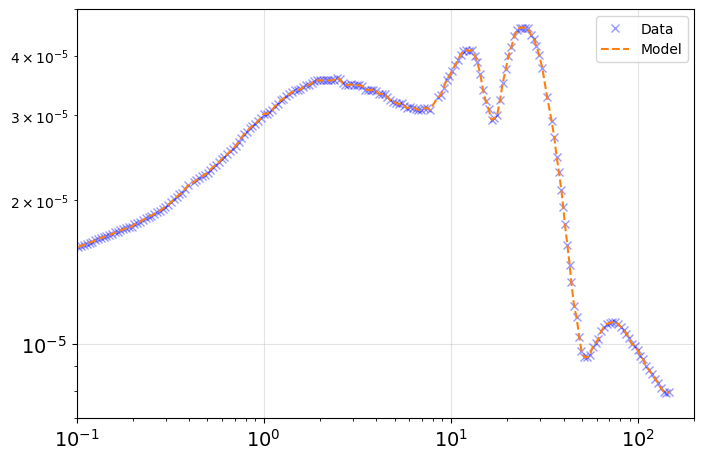

In [26]:
jung_plot = plt.figure(figsize=(1.5 * 13.5 / 2.54, 1.0 * 13.5 / 2.54))
plt.tick_params(labelsize=14)

plt.loglog(data_jung['x'], data_jung['y'], "bx", alpha=0.4, label="Data")
plt.loglog(data_jung['x'], jung_response(data_jung['x']), color="tab:orange", linestyle="--", label="Model")

plt.xlim(0.1, 200)
plt.ylim(7e-6, 5e-5)
plt.legend()
plt.grid(alpha=0.35)
plt.show()

In [27]:
# Prepare neutron spectra from Monte Carlo simulation
# Load and normalize neutron spectrum
# Chose material: LiF, Be, Cu, Ta
catcher_mc = "LiF"
# Chose angle at which the neutron spectrum is detected: 0° to 180° in 15° steps
angg = "0"
neutron_data_mc = np.loadtxt(open(f"./Data/Monte_Carlo/{catcher_mc}/{angg}deg_lin.cross").readlines()[:-19], 
                                 skiprows=151, usecols=(0,1,2,3), unpack=True)


# Smoothind neutron spectra to minimize influence of fluctiations due to sataistics.
neutron_data_mc[2] = savgol_filter(neutron_data_mc[2], 30, 10)
neutron_data_mc[3] = savgol_filter(neutron_data_mc[3], 30, 10)


# Generate energy grid from mid point of energy bin
e_grid = (neutron_data_mc[0] + neutron_data_mc[1])/2
n_norm_fact = metrics.auc(e_grid, neutron_data_mc[2])
print(n_norm_fact)
# Normalize differential neutron spectrum
dNdE_spectrum_norm = neutron_data_mc[2]/n_norm_fact
# Generate and normalize neutron spectrum
n_spectrum = neutron_data_mc[2] * (neutron_data_mc[1] - neutron_data_mc[0])
n_spectrum_norm = n_spectrum/n_norm_fact

# Get uncertainty from simulation run
spectrum_rel_uncert = neutron_data_mc[3]
# del neutron_data_mc, n_spectrum
print(f"Integral of normalized spectrum: {metrics.auc(neutron_data_mc[1], dNdE_spectrum_norm)}")

3.6581010189912867e-06
Integral of normalized spectrum: 0.9999999999999999


In [28]:
cjung = c_eff_jung(e_grid, dNdE_spectrum_norm, jung_response(e_grid))
print(f"c_eff for Jung response: {round(cjung * 1e5, 3)}e-5")

c_eff for Jung response: 3.304e-5


In [29]:
delta_cjung = cjung * delta_c_eff_jung(dNdE_spectrum_norm, spectrum_rel_uncert, jung_response(e_grid), 0)
print(f"Delta c_eff Jung: {round(delta_cjung * 1e5, 3)}e-5")

Delta c_eff Jung: 0.11e-5
